## NOTEBOOK 09

In this notebook we will implement a genetic algorithm (GA) to solve the Travel Salesman Problem (TSP) in different configurations.

Genetic algorithm's can be very different one to the others, but they all share common characteristics:

- an encoding of solution candidates
- a way to initialize a population
- a way to evaluate the fitness of each individual
- selection methods
- genetic operators (mutations, crossovers, n-parents operators)
- a termination criterion


In [2]:
import numpy as np
import matplotlib.pyplot as plt

### EXERCISE 09.1

#### The object-oriented approach

To create a program which performs a genetic algorithm to find the solution of the TSP, I decided to follow an object-oriented approach.

I created four main classes: city, map, individual and population.

- **city** is a simple class that contains the position of a city on a 2D plane and is able to print it out

- **map** is more interesting, since is essentially a collection of cities, but is also able to create a specific configuration of them, i.e. on a circle of radius $r$ or inside a square of edge $l$. Moreover, the map class, once initialized with the list of the cities, calculates the $d$ matrix, namely the matrix that contains at the entry $d_{ij}$ the euclidean distance between the i-th and the j-th city

- **individual** is the class the contains a single solution candidate. It contains the tour encoded as a permutation of the cities and the lenght of the total tour. Through this class we can also perform the single parent mutation operators we have implemented.

- **population** is more than a collection of individuals. Using the population class, we can effectively perform the genetic algorithm: we can sort the different members of the population by mean of their tour's lenght, we can select them using a _biased roulette wheel_ or preserving the most promising individuals through _elitism_




#### The mutation operators

The mutation operators implemented are:

- **single swap**: this operator choose randomly two cities inside an individual and swap them,e.g. $\left[ 1, 2, 3, 4, 5 \right] \to \left[ 1, 2, 4, 3, 5 \right]$ if we swap city $3$ and $4$, leaving always the first city fixed

#### Crossover

The crossover operators selects two parents randomly (at this point there's no fitness-based crossover implemented)

$$
\left[ 1, 2, 3, 4, 5 \right]\\
\left[ 1, 5, 4, 3, 2 \right] 
$$

and performs a crossover in this way:

1. cut their paths at the samer random position (here after the third city):


$$
\left[ 1, 2, 3 | 4, 5 \right]\\
\left[ 1, 5, 4 | 3, 2 \right] 
$$


2. conserve the first part of the paths:
$$
\left[ 1, 2, 3 | X, Y \right]\\
\left[ 1, 5, 4 | X, Y \right] 
$$


3. complete the paths with the missing cities adding them in the **order** in which they appear in the consort:


$$
\left[ 1, 2, 3 | 5, 4 \right]\\
\left[ 1, 5, 4 | 2, 3 \right] 
$$


the two sons will replace the two parents (there's no surviving of the fittest between parents and children).

The code implementing the crossover is the following

```c++

void Crossover(individual * t1,individual * t2){
	vector<int> p1=t1->Get_genes();
	vector<int> p2=t2->Get_genes();

	int size=p1.size();

	vector<int> s1;
	vector<int> s2;

	uniform_int_distribution<> dist(0,size-1);

	int r=dist(mt);

	for(int i=0;i<r;i++){
		s1.push_back(p1[i]);
		s2.push_back(p2[i]);
	}

	for(int i=0;i<size;i++){

		int a=p1[i];
		int b=p2[i];

		if(any_of(p1.begin()+r,p1.end(),[b](int k){return k==b;})){
			s1.push_back(p2[i]);
		}
		if(any_of(p2.begin()+r,p2.end(),[a](int k){return k==a;})){
			s2.push_back(p1[i]);
		}
	}

	t1->Set_genes(s1);
	t2->Set_genes(s2);
}

```

Where the <code> algorithm.h </code> library is used to complete a parent with the missing cities using the order of the other.

#### The selection methods

In this code I implemented inside the _population_ class two selection methods:

- **classical roulette wheel selection**: this selection method is fitness based, since every individual will have a chance to survive to the next evolutive step based on the lenght of its tour. For every evolutive step $n_{pop}$ spins of the wheel are performed and every individual $i$ will have a probability 

$$
p_{i}=\frac{1}{Z}\big(1-\frac{l_{i}}{l_{max}}\big)
$$

  to be chosen, where $Z = \sum_{i=1}^{n_{pop}} 1-\frac{l_{i}}{l_{max}}$ is the normalization factor.
  
- **roulette wheel with elitism**: the same algorithm is performed, but now before performing crossovers, mutations and selection, the best $n_{elite}$ solution candidates are saved and passed to the next generation (after being saved, their copies will enter the modification and selection path together with the other candidates)

#### Initializing the cities

After finishing writing the code, the first thing to do is to create a list of cities.

Here I generated 32 cities

- on a circumference of $r=10$
- inside a square of $l=20$


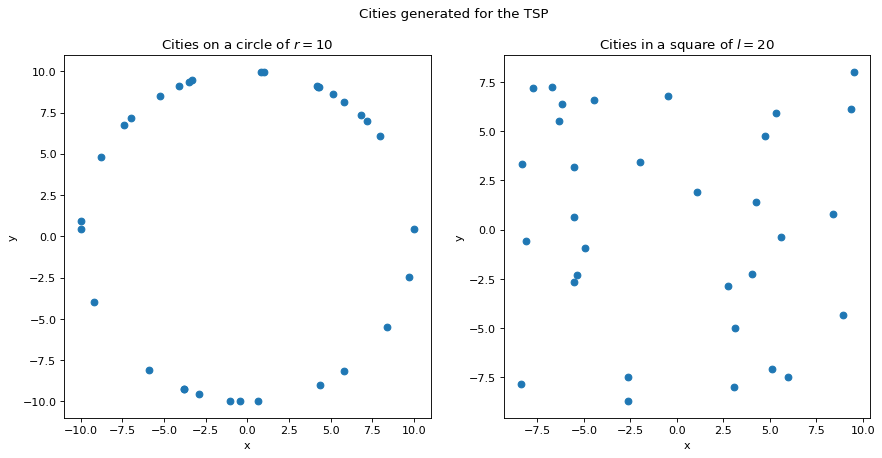

In [15]:
circle=np.loadtxt("circle.dat")
square=np.loadtxt("square.dat")

xc=np.zeros(len(circle))
yc=np.zeros(len(circle))

xs=np.zeros(len(square))
ys=np.zeros(len(square))

for i in range(len(xc)):
    xc[i]=circle[i][0]
    yc[i]=circle[i][1]
    
for i in range(len(xs)):
    xs[i]=square[i][0]
    ys[i]=square[i][1]
    
    
##Plot

fig, (ax1,ax2)=plt.subplots(1,2,figsize=(13,6), dpi=80)

fig.suptitle("Cities generated for the TSP")

ax1.scatter(xc,yc)
ax1.set_title('Cities on a circle of $r=10$')
ax1.set(xlabel='x', ylabel='y')


ax2.scatter(xs,ys)
ax2.set_title('Cities in a square of $l=20$')
ax2.set(xlabel='x', ylabel='y')

plt.show()
plt.close()

#### The solutions of the cricle case

We start studying the circle case, we apply to it both the classical roulette wheel and the elitism one.

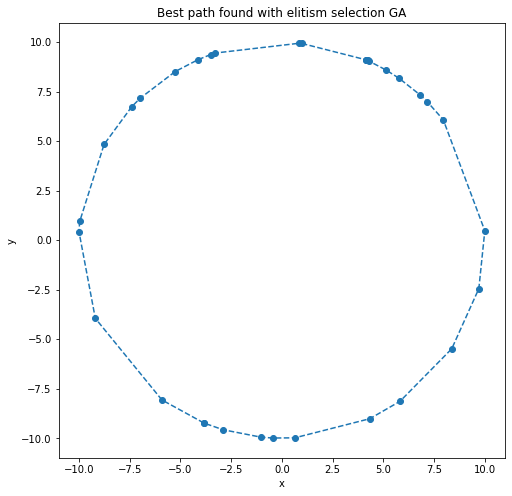

In [17]:
ce_best_ind=np.loadtxt("results/ind_best_circle.dat")
ce_best_ind=[int(x) for x in ce_best_ind]

xb=np.zeros(len(circle)+1)
yb=np.zeros(len(circle)+1)



for i in range(len(circle)):
    xb[i]=circle[ce_best_ind[i]][0]
    yb[i]=circle[ce_best_ind[i]][1]
    
xb[len(circle)]=xb[0]
yb[len(circle)]=yb[0]


plt.figure(figsize=(8,8))
plt.title("Best path found with elitism selection GA")
plt.plot(xb,yb, marker='o',linestyle='dashed')
plt.xlabel("x")
plt.ylabel("y")

plt.show()
plt.close()